In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: michalewicz

include("../lib/gif.jl")

plot_animation (generic function with 1 method)

In [2]:
f = michalewicz(10)

plt.default(label=false, colorbar=false)
plotsize = (540, 540)

xdomain = LinRange(0, 4, 400)
ydomain = LinRange(0, 4, 400)

function plot_heatmap_and_population(population; size=plotsize)
    plot = plt.heatmap(xdomain, ydomain, (x, y) -> f([x, y]); color=plt.cgrad(:haline), xaxis=false, yaxis=false, size=size)
    population_size = Base.size(population)[1]
    if population_size > 0
        plt.scatter!(
            plot,
            [individual[1] for individual in population],
            [individual[2] for individual in population],
            markershape=:circle,
            markersize=2.5,
            markerstrokewidth=0
        )
    end
    return plot
end

# plot_heatmap_and_population([])

plot_heatmap_and_population (generic function with 1 method)

"Optimum: x=[2.2036, 1.5711]"

  0.262396 seconds (438.53 k allocations: 23.018 MiB, 99.26% compilation time)


┌ Info: Saved animation to 
│   fn = /tmp/jl_P89SjAHMZo.gif
└ @ Plots /home/nguymin4/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_P89SjAHMZo.gif")
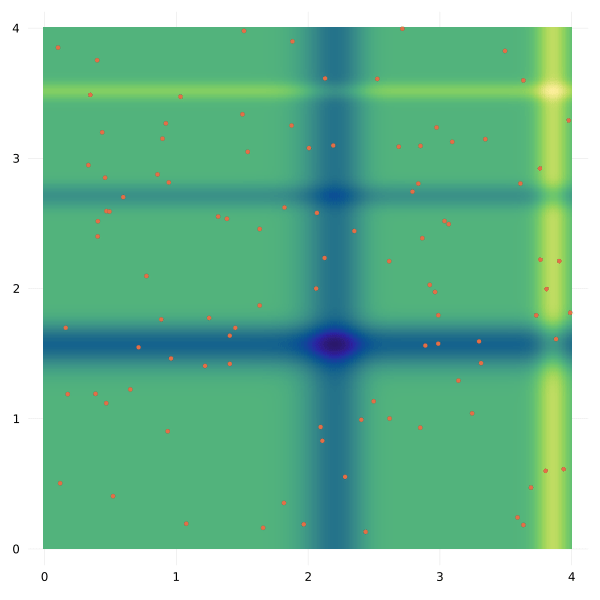

In [6]:
import Random
import Distributions

Random.seed!(0)

# Initialize
abstract type PopulationInit end

struct UniformPopulationInit <: PopulationInit
    lower_bounds::Vector{Float64}
    upper_bounds::Vector{Float64}
end
function initialize_population(population_size::Int64, method::UniformPopulationInit)
    population = nothing
    for (lb, ub) in zip(method.lower_bounds, method.upper_bounds)
        population_at_dim = rand(Distributions.Uniform(lb, ub), population_size)'
        population = population == nothing ? population_at_dim : vcat(population, population_at_dim)
    end
    return [individual[:] for individual in eachcol(population)]
end

# Selection
abstract type SelectionMethod end

struct TruncationSelection <: SelectionMethod
    k::Int64
end
function select(method::TruncationSelection, y::Vector{Float64})
    p = sortperm(y)
    return [p[rand(1:method.k, 2)] for _ in y]
end

struct TournamentSelection <: SelectionMethod
    k::Int64
end
function select(method::TournamentSelection, y::Vector{Float64})
    function get_parent()
        candidates = Random.randperm(length(y))[1:method.k]
        return candidates[argmin(y[candidates])]
    end
    return [[get_parent(), get_parent()] for _ in y]
end

struct RouletteWheelSelection <: SelectionMethod end
function select(::RouletteWheelSelection, y::Vector{Float64})
    fitness = maximum(y) .- y
    cat = Distributions.Categorical(normalize(fitness, 1))
    return [rand(cat, 2) for _ in y]
end

# Crossover
abstract type CrossOverMethod end

struct SinglePointCrossOver <: CrossOverMethod end
function crossover(::SinglePointCrossOver, parentA::Vector{Float64}, parentB::Vector{Float64})
    split_point = rand(1:length(parentA))
    return vcat(parentA[1:split_point], parentB[split_point+1:end])
end

struct TwoPointCrossOver <: CrossOverMethod end
function crossover(::TwoPointCrossOver, parentA::Vector{Float64}, parentB::Vector{Float64})
    i, j = sort(rand(1:length(parentA), 2))
    return vcat(parentA[1:i], parentB[i+1:j], parentA[j+1:end])
end

struct UniformCrossOver <: CrossOverMethod end
function crossover(::UniformCrossOver, parentA::Vector{Float64}, parentB::Vector{Float64})
    child = copy(parentA)
    mask = rand(Float64, length(parentA)) .< 0.5
    child[mask] = parentB[mask]
    return child
end

struct InterpolationCrossOver <: CrossOverMethod
    λ::Float64
end
function crossover(method::InterpolationCrossOver, parentA::Vector{Float64}, parentB::Vector{Float64})
    return (1 - method.λ) * parentA + method.λ * parentB
end

# Mutation
abstract type MutationMethod end

struct BitwiseMutation <: MutationMethod
    λ::Float64
end
function mutate(method::BitwiseMutation, child::Vector{Float64})
    return [rand() < method.λ ? !v : v for v in child]
end

struct GaussianMutation <: MutationMethod
    σ::Float64
end
function mutate(method::GaussianMutation, child::Vector{Float64})
    return child + randn(length(child)) * method.σ
end

# Genetic Algorithm
function genetic_algorithm(
    f;
    population_init_method::PopulationInit,
    selection_method::SelectionMethod,
    crossover_method::CrossOverMethod,
    mutation_method::MutationMethod,
    max_iter=10,
    population_size=100
)
    history = []
    population = initialize_population(population_size, population_init_method)
    push!(history, population)
    y = f.(population)
    for _ in 1:max_iter
        parents = select(selection_method, y)
        children = [crossover(crossover_method, population[parent[1]], population[parent[2]]) for parent in parents]
        population = mutate.(Ref(mutation_method), children)
        push!(history, population)
        y = f.(population)
    end
    return population[argmin(y)], history
end

x, history = @time genetic_algorithm(
    f;
    population_size=100,
    population_init_method=UniformPopulationInit([0.0, 0.0], [4.0, 4.0]),
    # selection_method=TruncationSelection(50),
    selection_method=TournamentSelection(20),
    # selection_method=RouletteWheelSelection(),
    # crossover_method=SinglePointCrossOver(),
    # crossover_method=UniformCrossOver(),
    crossover_method=InterpolationCrossOver(0.5),
    mutation_method=GaussianMutation(0.1),
    max_iter=5
)
display("Optimum: x=$(round.(x, digits=4))")
plot_animation(plot_heatmap_and_population, history)